In [51]:
import random as r
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as ss
from scipy import stats
import numpy as np
from itertools import groupby
import matplotlib.pyplot as plt

import matplotlib

In [2]:
factor_1 = 'GenderID'
factor_2 = 'MarriedID'
target   = 'PayRate'

In [3]:
def flattenize(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [4]:
def get_targets_grouped_by_factor(target, factor, dataframe):
    tupled_factor_and_target =  [z for z in zip(dataframe[factor], dataframe[target])]

    unique_levels = sorted(set([i[0] for i in tupled_factor_and_target]))

    level_groups = []
    for level in unique_levels:
        print("Processing Factor: {} | Level: {}".format(factor, level))
        level_subgroup = [x[1] for x in tupled_factor_and_target if x[0] == level]
        level_groups.append(level_subgroup)
    
    return level_groups

In [5]:
hr_ds = pd.read_csv('hr_dataset.csv')
len(hr_ds)

401

In [6]:
hr_ds = hr_ds.dropna(how='all')
len(hr_ds)

310

In [7]:
hr_ds.tail(2)

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,...,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30
308,"South, Joe",1.308061e+09,0.0,0.0,1.0,1.0,3.0,3.0,0.0,53.0,...,IT/IS,Peter Monroe,7.0,Employee Referral,Fully Meets,5.00,3.0,4.0,1/2/2019,0.0
309,"Warfield, Sarah",1.301052e+09,0.0,4.0,0.0,1.0,3.0,3.0,0.0,55.2,...,IT/IS,Peter Monroe,7.0,Employee Referral,Fully Meets,1.06,4.0,8.0,2/5/2019,0.0


In [8]:
hr_ds_for_plots = hr_ds.copy()

In [9]:
hr_ds_for_plots.loc[hr_ds_for_plots['GenderID'] == 1, 'GenderID']   = 'male'
hr_ds_for_plots.loc[hr_ds_for_plots['GenderID'] == 0, 'GenderID']   = 'female'

In [10]:
ds_to_evaluate = hr_ds.copy()
ds_to_evaluate = ds_to_evaluate[[factor_2, factor_1, target]]
ds_to_evaluate.dtypes

MarriedID    float64
GenderID     float64
PayRate      float64
dtype: object

In [11]:
print("Null values in MarriedID: {}".format(ds_to_evaluate.MarriedID.isnull().values.any()))
print("Null values in PayRate: {}".format(ds_to_evaluate.PayRate.isnull().values.any()))
print("Null values in GenderID: {}".format(ds_to_evaluate.GenderID.isnull().values.any()))

Null values in MarriedID: False
Null values in PayRate: False
Null values in GenderID: False


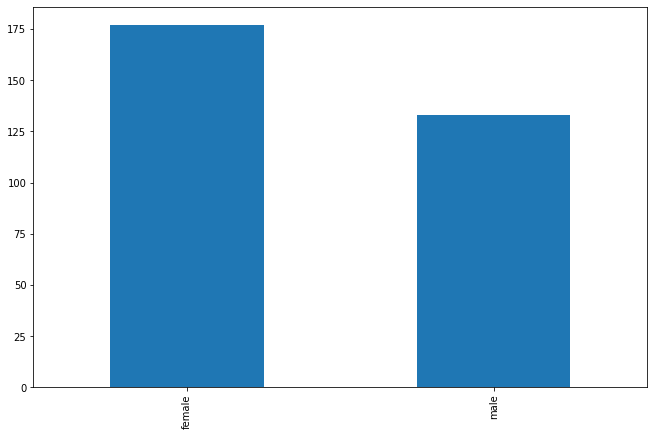

In [12]:
plt.figure(figsize=(11, 7))
hr_ds_for_plots['GenderID'].value_counts().plot(kind='bar')

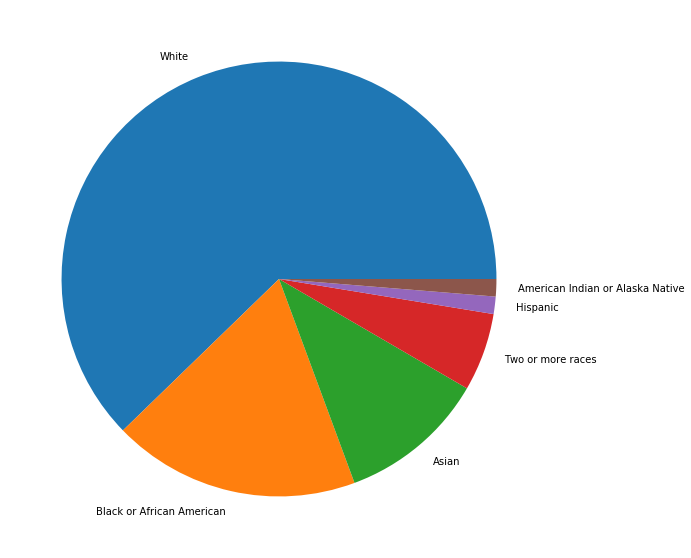

In [13]:
index  = hr_ds_for_plots['RaceDesc'].value_counts().index
values = hr_ds_for_plots['RaceDesc'].value_counts()

plt.figure(figsize=(16, 10))
temp = plt.pie(values, labels = index)

In [14]:
hr_ds_for_plots.loc[hr_ds_for_plots['MarriedID'] == 1, 'MarriedID']   = 'yes'
hr_ds_for_plots.loc[hr_ds_for_plots['MarriedID'] == 0, 'MarriedID']   = 'no'

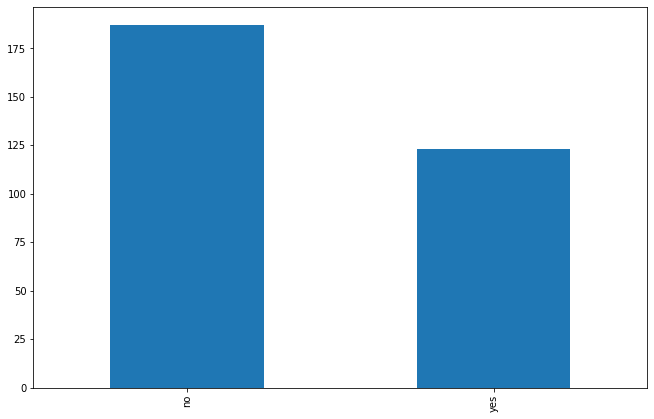

In [15]:
plt.figure(figsize=(11, 7))
hr_ds_for_plots['MarriedID'].value_counts().plot(kind='bar')

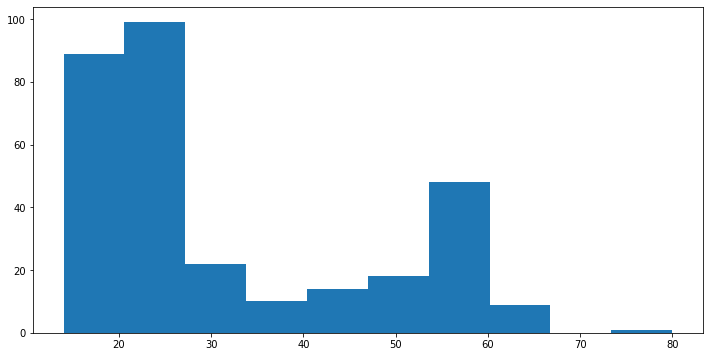

In [16]:
plt.hist(ds_to_evaluate[target])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6)
plt.show()

In [17]:
factor_1_grouped = get_targets_grouped_by_factor(target, factor_2, ds_to_evaluate)
factor_2_grouped = get_targets_grouped_by_factor(target, factor_1, ds_to_evaluate)

Processing Factor: MarriedID | Level: 0.0
Processing Factor: MarriedID | Level: 1.0
Processing Factor: GenderID | Level: 0.0
Processing Factor: GenderID | Level: 1.0


In [20]:
print(len(factor_1_grouped))
print(len(factor_2_grouped))

2
2


In [21]:
print("factor_1 - genederID_ {}".format(ss.bartlett(*factor_1_grouped)))
print("factor_2 - marriedID_ {}".format(ss.bartlett(*factor_2_grouped)))

factor_1 - genederID_ BartlettResult(statistic=0.5307906487506534, pvalue=0.4662746439205244)
factor_2 - marriedID_ BartlettResult(statistic=1.5867451970193318, pvalue=0.20779177139080507)


In [62]:
ds_to_evaluate.tail(5)

,MarriedID,GenderID,PayRate
305,1.0,0.0,54.1
306,1.0,1.0,56.2
307,1.0,1.0,53.8
308,0.0,1.0,53.0
309,0.0,0.0,55.2


In [23]:
mlm = ols(target + ' ~ C(' + factor_1 + ', Sum)*C(' + factor_2 + ', Sum)', data = ds_to_evaluate).fit()

In [24]:
anova_result = sm.stats.anova_lm(mlm, typ=2) 

In [25]:
anova_result

,sum_sq,df,F,PR(>F)
"C(GenderID, Sum)",1368.716353,1.0,5.840812,0.016243
"C(MarriedID, Sum)",63.907653,1.0,0.272717,0.601893
"C(GenderID, Sum):C(MarriedID, Sum)",0.107373,1.0,0.000458,0.982936
Residual,71707.020472,306.0,NaN,NaN


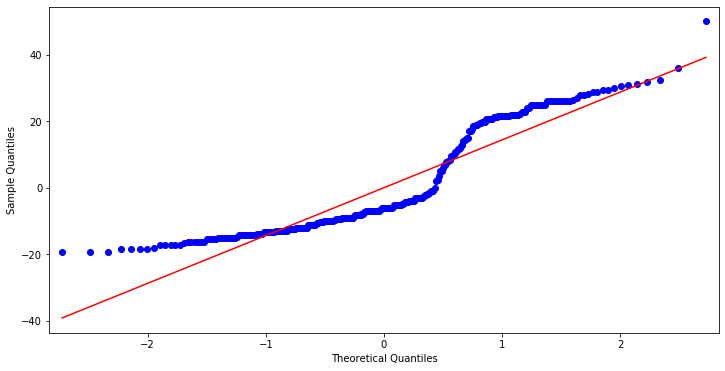

In [58]:
fig = sm.qqplot( mlm.resid , line='r', dist=stats.norm)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6)
plt.show()

In [27]:
not_married_woman = np.mean(ds_to_evaluate[(ds_to_evaluate['MarriedID'] == 0) & (ds_to_evaluate['GenderID'] == 0)]['PayRate'])
married_women = np.mean(ds_to_evaluate[(ds_to_evaluate['MarriedID'] == 1) & (ds_to_evaluate['GenderID'] == 0)]['PayRate'])
not_married_men = np.mean(ds_to_evaluate[(ds_to_evaluate['MarriedID'] == 0) & (ds_to_evaluate['GenderID'] == 1)]['PayRate'])
married_men = np.mean(ds_to_evaluate[(ds_to_evaluate['MarriedID'] == 1) & (ds_to_evaluate['GenderID'] == 1)]['PayRate'])

In [28]:
gender = ['Married', 'Not Married']

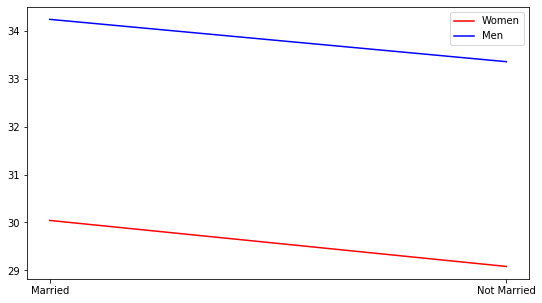

In [29]:
plt.plot(gender, [married_women, not_married_woman], color='r', label='Women')
plt.plot(gender, [married_men, not_married_men], color='b', label='Men')

plt.legend(loc="upper right")

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 5)
plt.show()